In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».




# Шаг 1. Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene
import os

pth1 = 'games.csv'
pth2 = './datasets/games.csv'
pth3 = '/datasets/games.csv'
pth4 = '/content/drive/MyDrive/Colab Notebooks/datasets/games.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
elif os.path.exists(pth4):
    df = pd.read_csv(pth4)
else:
    print("Проверьте правильность пути к датасету")


df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Шаг 2. Подготовьте данные

## Проверка явных и неявных дубликатов



In [ ]:
# поиск явных дубликатов
print(df[df.iloc[:,0:3].duplicated(keep='first')])
print(df[df.iloc[:,0:3].duplicated(keep='last')]) # выводим строки с дубликатами чтобы решить что оставляем

df = df.drop_duplicates(subset=df.columns[:3], keep='first') # удаляем повтор в котором не было данных востребованных данных

print('Осталось дубликатов: ', df.duplicated(subset=df.columns[:3]).sum())


                Name Platform  Year_of_Release   Genre  NA_sales  EU_sales  \
14244            NaN      GEN           1993.0     NaN       0.0      0.00   
16230  Madden NFL 13      PS3           2012.0  Sports       0.0      0.01   

       JP_sales  Other_sales  Critic_Score User_Score Rating  
14244      0.03          0.0           NaN        NaN    NaN  
16230      0.00          0.0          83.0        5.5      E  
              Name Platform  Year_of_Release   Genre  NA_sales  EU_sales  \
604  Madden NFL 13      PS3           2012.0  Sports      2.11      0.22   
659            NaN      GEN           1993.0     NaN      1.78      0.53   

     JP_sales  Other_sales  Critic_Score User_Score Rating  
604       0.0         0.23          83.0        5.5      E  
659       0.0         0.08           NaN        NaN    NaN  
Осталось дубликатов:  0


In [ ]:
# поиск неявных дубликатов:
print('Уникальные значения столбца Platform: ', df.iloc[:,1].sort_values().unique())

print('Уникальные значения столбца Year_Of_Release: ', df.iloc[:, 2].sort_values().unique())

duplic =( #объединили все три столбца без пробелов, привели их к нижнему регистру
    df.iloc[:, :3]
    .astype(str)
    .agg(''.join, axis=1)
    .str.lower()
)

print('Дубликатов в связке Имя+Платформа+Год: ', duplic.duplicated().sum())

Уникальные значения столбца Platform:  ['2600' '3DO' '3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'GEN' 'GG' 'N64' 'NES' 'NG'
 'PC' 'PCFX' 'PS' 'PS2' 'PS3' 'PS4' 'PSP' 'PSV' 'SAT' 'SCD' 'SNES' 'TG16'
 'WS' 'Wii' 'WiiU' 'X360' 'XB' 'XOne']
Уникальные значения столбца Year_Of_Release:  [1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016.   nan]
Дубликатов в связке Имя+Платформа+Год:  0


## Замените названия столбцов (приведите к нижнему регистру);

Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;

In [ ]:
df.columns = df.columns.str.lower() # приводим заголовки столбцов к нижнему регистру

#df['name'] = df['name'].dropna()

#df['year_of_release'] = df['year_of_release'].fillna(df['year_of_release'].median()).astype('int')

df['year_of_release'] = df['year_of_release'].dropna().astype('int') # меняем формат столбца с годом релиза, замещая отсутствующие занчения на медианные.

#df['critic_score'] = df['critic_score'].fillna(df['critic_score'].median()).astype('int')
df['critic_score'] = df['critic_score'].fillna(-1).astype('int') # значения в столбце оценки критиков целочисленные, меняем форматна int, подумав про пропуски.

## Обработайте пропуски при необходимости:

In [ ]:
print(df.isnull().sum())


#df['name'] = df['name'].fillna('unknown') # категориальные значения заменяем на unknown
#df['genre'] = df['genre'].fillna('unknown')
df = df.drop(index=df[(df['name'].isnull()) | (df['genre'].isnull())].index)

display(df['rating'].unique()) # для отсутствующих значений в рейтингах следует поставиь рейтинг "Rating Pending"
df['rating'] = df['rating'].fillna('RP') # рейтинг ожидается

# Изучаем структуру, получается, что к отсутствующим добавляем +2424 'tbd' значений. tbd - to be determined, что в переводе с английского означает - буду NaN
df['user_score'] = df['user_score'].replace('tbd', np.nan) # получилось 9125 отсутсвующих значений
df['user_score'] = df.user_score.astype('float') # приведем значения столбца к должному типу



name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         6700
rating             6765
dtype: int64


array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

## Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [ ]:
df['sales_all'] = df.iloc[:, 4:8].sum(axis=1) # объединяем нужные столбц
df.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1,NaN,RP,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,-1,NaN,RP,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,-1,NaN,RP,28.31


In [ ]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = df.copy()
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     16712 non-null  int64  
 9   user_score       7589 non-null   float64
 10  rating           16712 non-null  object 
 11  sales_all        16712 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.7+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio: Instant Artist' 'wwe Smackdown vs. Raw 2006'
 '¡Shin Chan Flipa e

**Вывод по предобработке:** В представленом датасете почти не наблюдалось явных\неявных дубликатов. Пропуски в присутствуют в столбцах с оценками и рейтингами, а значения отсутствуют обычно попарно. Есть основания предполагать, что они связаны в основном человеческим фактором, а не с ошибками при выгрузке данных. Игра может быть слишком новой или слишком старой, а так же локальные ограничения по применению рейтинга ESRB в различных странах.

# Шаг 3. Проведите исследовательский анализ данных

## Сколько игр выпускалось в разные годы.
Важны ли данные за все периоды?

<Axes: title={'center': 'Выпустилось игр за год'}, xlabel='Год', ylabel='Количество игр'>

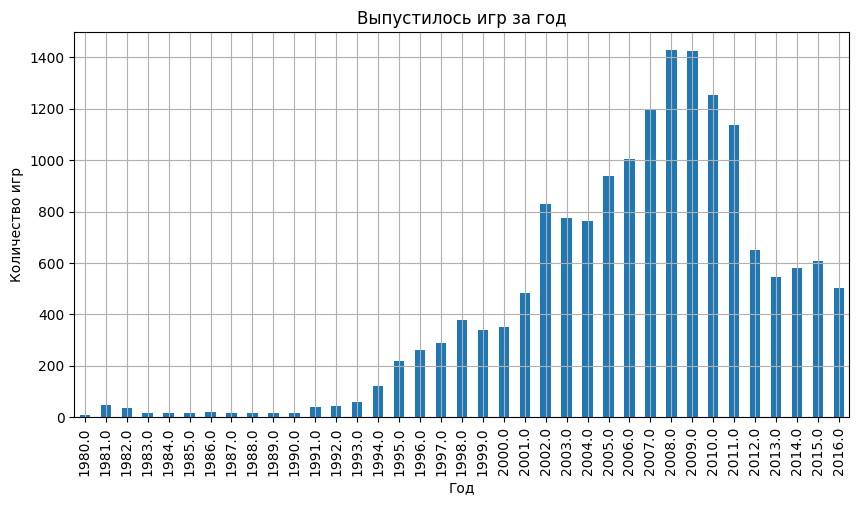

In [ ]:
#df.groupby('year_of_release')['name'].count().plot(kind='bar', title='Выпустилось игр за год', grid=True, xlabel='Год', ylabel='Количество игр')
df.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(10,5), title='Выпустилось игр за год', grid=True, xlabel='Год', ylabel='Количество игр')

Графки за все периоды показывает нам, что рынок игроделов сжался после конца нулевых.
В реальности же это может быть связано  с трансформацией индустрии в целом и нарастающим преобладанием цифровой дистрибуции видеоигр над физическими носителями.

## Как менялись продажи по платформам.

Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

<Axes: title={'center': 'Какие платформы продавались наиболее часто'}, xlabel='Платформа', ylabel='Продажи'>

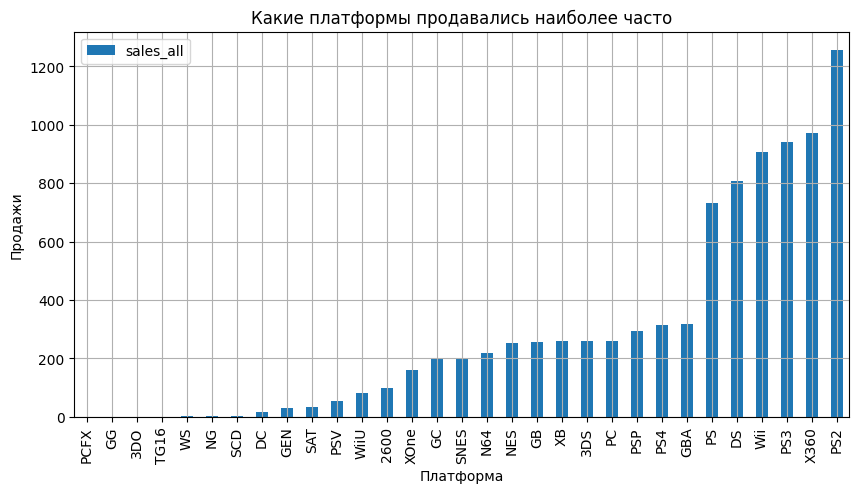

In [ ]:
( # выбираю платформы с наибольшими sumмарными продажами
    df
     .pivot_table(index='platform', values='sales_all', aggfunc='sum')
     .sort_values('sales_all')
     .plot(kind='bar', figsize=(10,5), title='Какие платформы продавались наиболее часто', grid=True, xlabel='Платформа', ylabel='Продажи')
)

По диаграмме видно что наибольшие продажи имеют 6 платформы: PS, DS, Wii, PS3, x360, PS2. Построим для каждой популярной платформы распределение продаж по годам.

<Axes: title={'center': 'Наибольшие суммарные продажи по платформам'}, xlabel='Год релиза', ylabel='Объём продаж'>

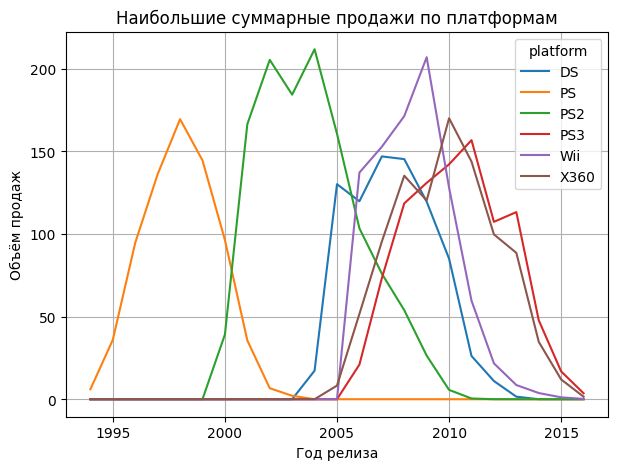

In [ ]:
#top_platforms = ['PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']
top_platforms = df.groupby('platform')['sales_all'].sum().sort_values(ascending=False).index[:6]
(
    df
     .query('platform in @top_platforms & year_of_release >= 1990') # выберем в датафрейме интересующие нас категории с условием и срежем
     .pivot_table(index='year_of_release', columns='platform', values='sales_all', aggfunc='sum', fill_value=0) # сделаем сводную таблицу для изучения нужных нам параметров в срезе. fillvalue чтобы линия следовала снизу
     .plot(figsize=(7, 5),title='Наибольшие суммарные продажи по платформам', grid=True, xlabel='Год релиза', ylabel='Объём продаж')
)

In [ ]:
# Комментарий ревьюера
temp = df.copy()
list(temp.groupby('platform')['sales_all'].sum().sort_values(ascending=False).index[:6])

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

>Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов.
Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы

**Ответ**: Актуальным является период с 2012 года по 2016. Именно в течение 4-х летнего периода платформы показывают максимальные продажи, то есть платформы остаются актуальными.

Смена актуальности видна на графике на примере Playstation, она занимает тоже  в среднем 4 года, после чего видно пересечение на графике  и на лидирующие позиции выходит новая платформа.

## Какие платформы лидируют по продажам, растут или падают?
Выберите несколько потенциально прибыльных платформ.



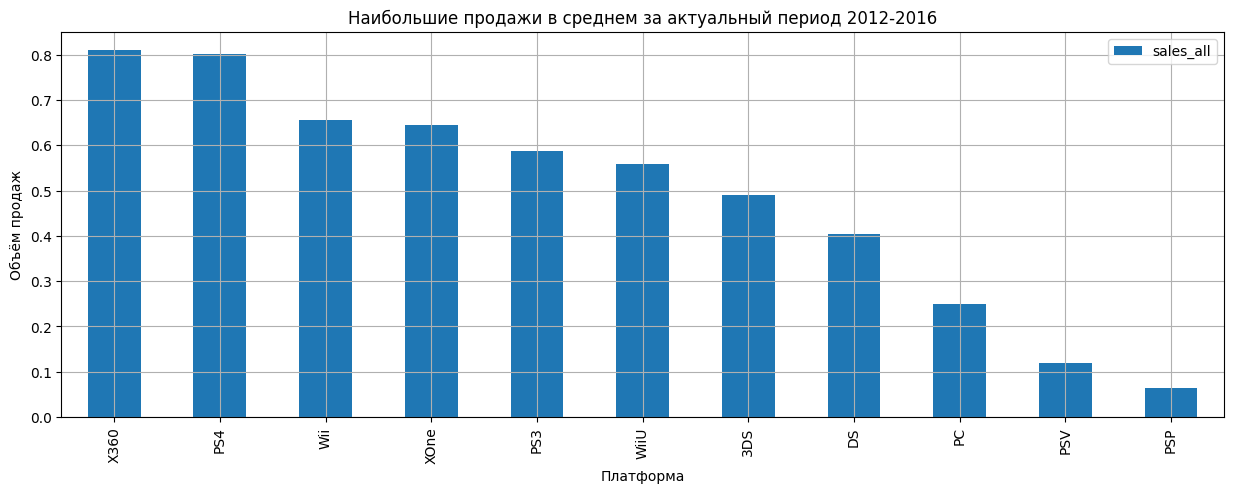

In [ ]:
df_actual = df.query('year_of_release >= 2012')
(
    df_actual
     .pivot_table(index='platform', values='sales_all', aggfunc='mean')
     .sort_values('sales_all', ascending = False)
     .plot(kind='bar', figsize=(15, 5), title='Наибольшие продажи в среднем за актуальный период 2012-2016', grid=True, xlabel='Платформа', ylabel='Объём продаж')
)
plt.show()

ТОП-5 прибыльных платформ: PS4, PS3, X360, 3DS, XOne.

## Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам.
Опишите результат.


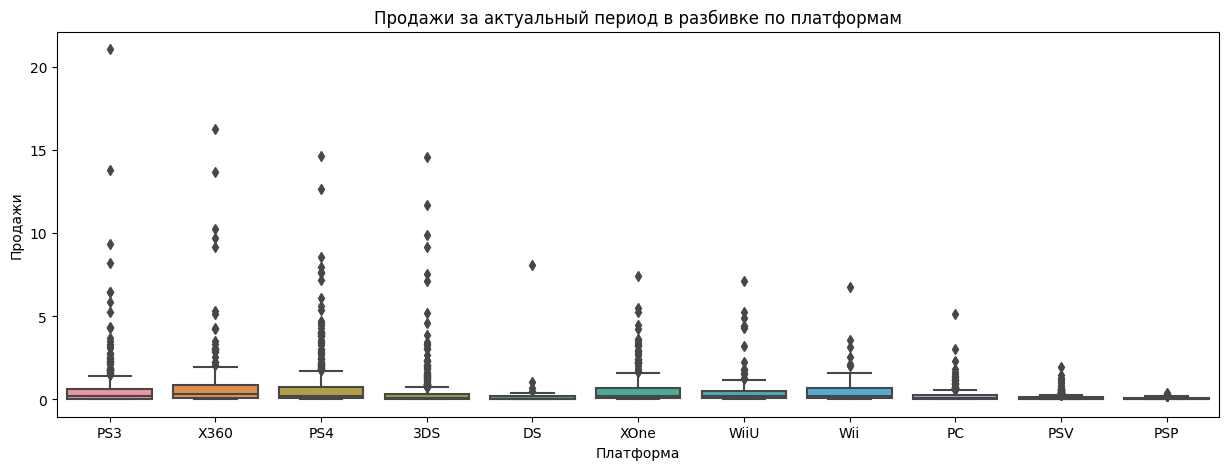

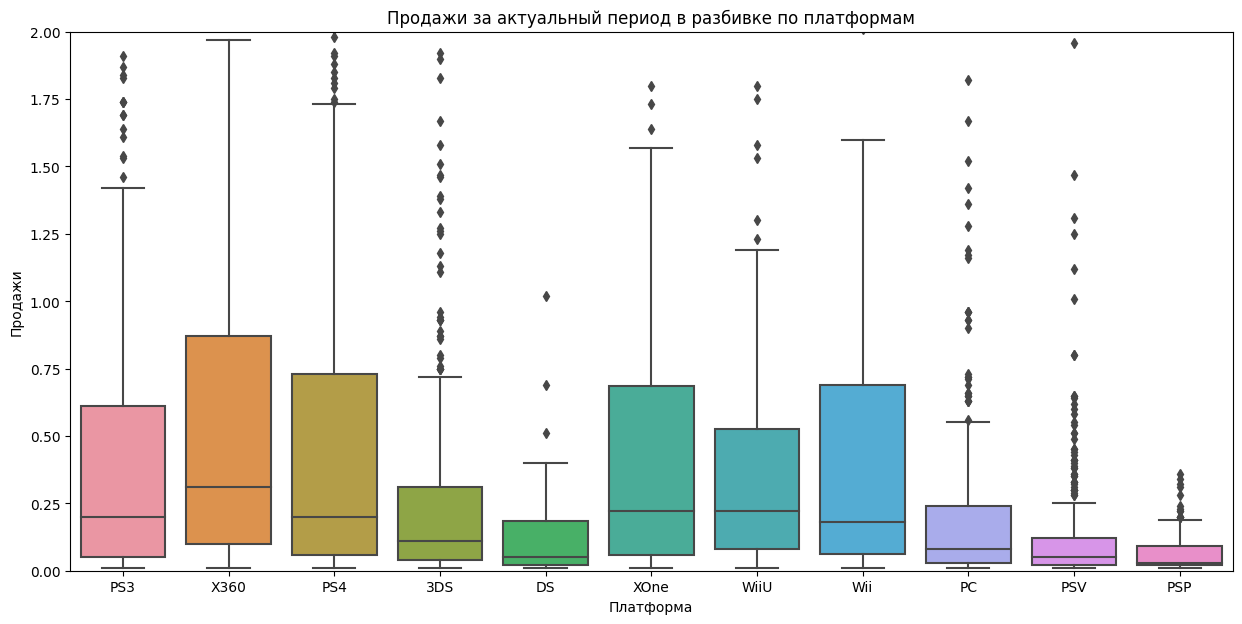

count    2885.000000
mean        0.501393
std         1.249340
min         0.010000
25%         0.040000
50%         0.120000
75%         0.430000
max        21.050000
Name: sales_all, dtype: float64

In [ ]:

plt.figure(figsize=(15,5))
sns.boxplot(x="platform", y="sales_all", data=df_actual)
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Продажи за актуальный период в разбивке по платформам')
plt.show()

plt.figure(figsize=(15,7))
sns.boxplot(x="platform", y="sales_all", data=df_actual)
plt.ylim(0,2)
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Продажи за актуальный период в разбивке по платформам')
plt.show()

df_actual['sales_all'].describe()

1. По графикам видно, что каждая из платформ имеет внушительное количество выбросов в данных по общим продажам. Лидируют по этому показателю **PS3, X360, PS4, 3DS**. Это популярные платформы, на которые приходится большое число выпушенных игр, что делает возможным ошибки в данных. Так же эти выбросы могли происходить в периоды наибольшей актуальности платформы и старты продаж бестселлеров.
2. Максимальный разброс нормальных значений до 2 млн. долларов наблюдаем у **X360**. Следом на отметке 1.75 млн. долларов **PS4**.
3. У большинства популярных платформ **медиана продаж** располагается на уровне **0.25 млн. долларов**. Лучший показатель на графике у X360 с медианой около 0.3 млн. долларов.
4. Соответственно медианами, по обьему продаж лидируют 5 платформы, у которых больше половины продаж, приходятся в диапазоне от 0.25 млн. долларов до 0.75. Лидер - **X360** c 0.9 млн. долларов. Следом идут **PS4, XOne, Wii, PS3**.

На графике прослеживается нарастающая популярность новых платформ **XOne,PS4, Wii**. Пускай им еще не удалось победить старое поколение по обьемам продаж и выбросам значений, но тенденции прослеживаются четко.



## Посмотрите, как влияют на продажи внутри одной популярной платформы **отзывы** **пользователей** и **критиков**.
Постройте диаграмму **рассеяния** и посчитайте **корреляцию** между отзывами и продажами. Сформулируйте выводы.


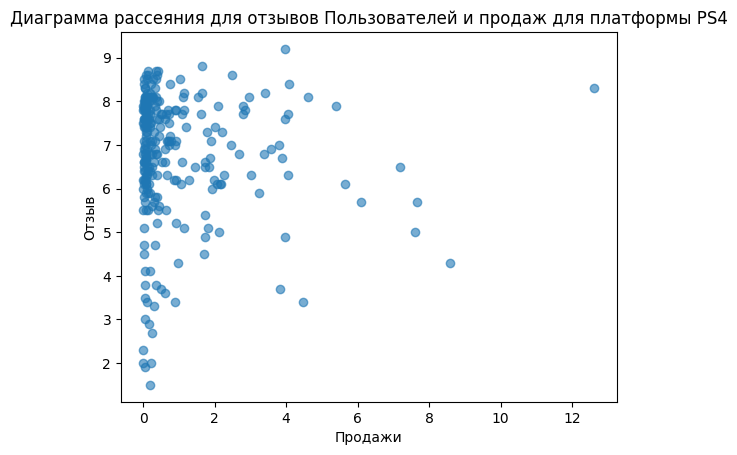

Коэффициент кореляции продаж и отзывов пользователей платформы PS4: -0.031957110204556424


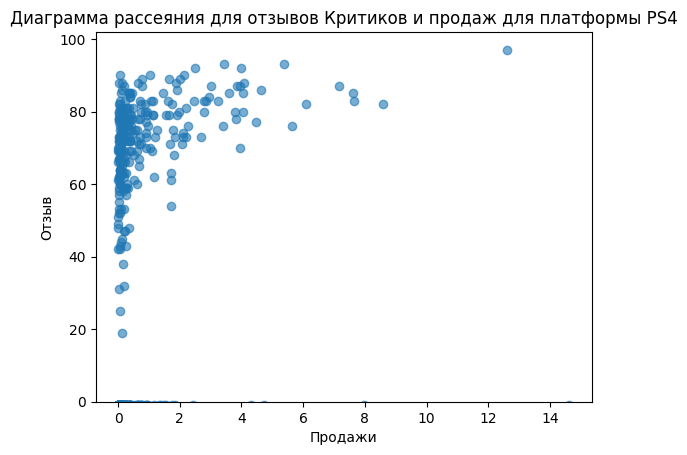

Коэффициент кореляции продаж и отзывов критиков платформы PS4: 0.22652606614612347


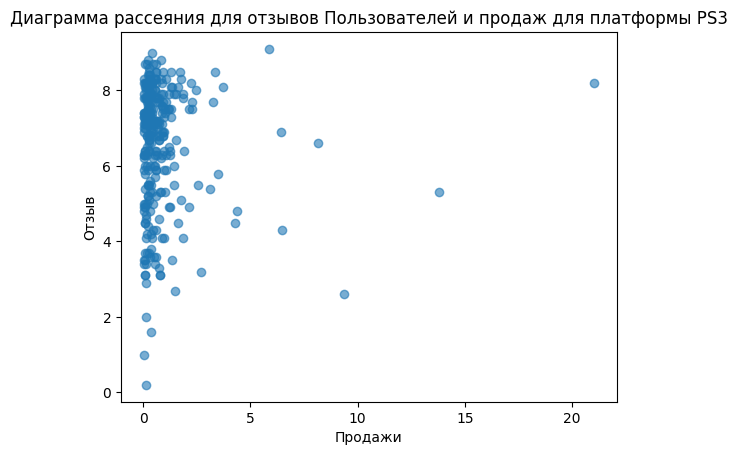

Коэффициент кореляции продаж и отзывов пользователей платформы PS3: -0.006205767686051499


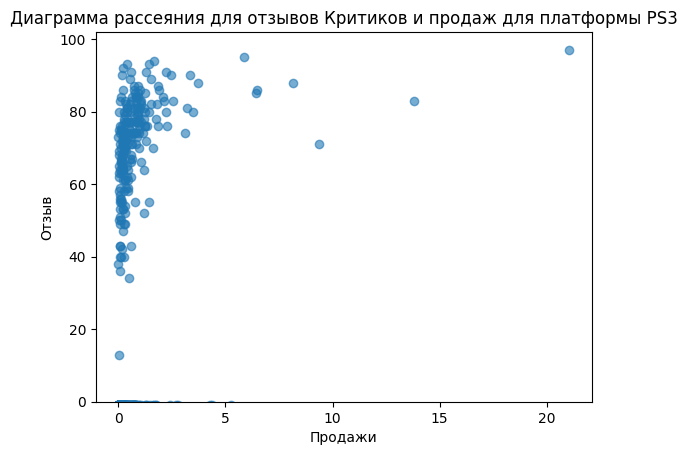

Коэффициент кореляции продаж и отзывов критиков платформы PS3: 0.30000100510820094


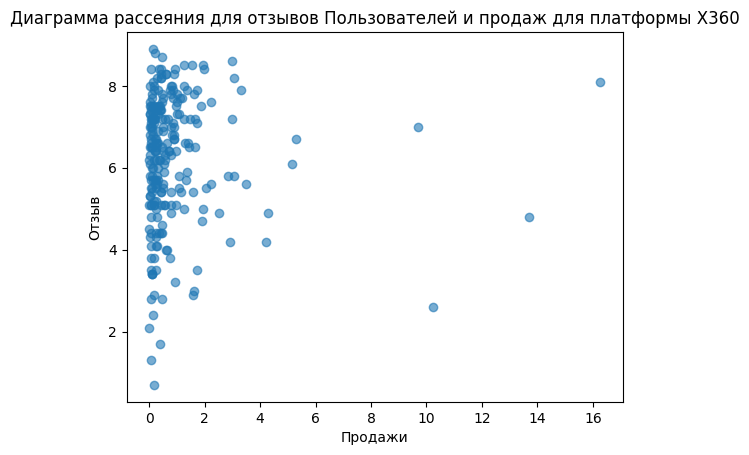

Коэффициент кореляции продаж и отзывов пользователей платформы X360: 0.006163978646213326


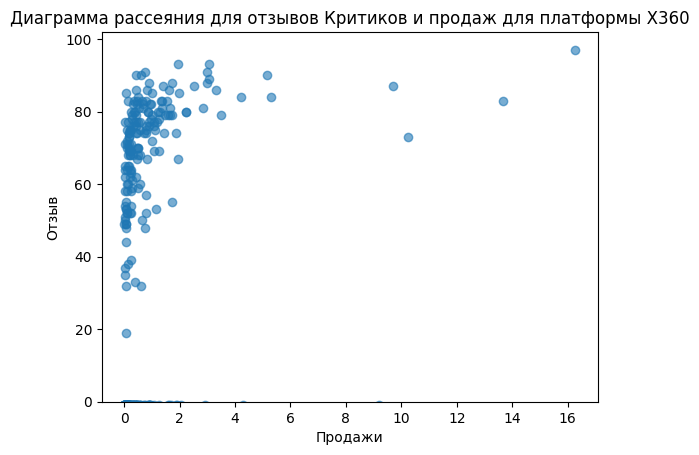

Коэффициент кореляции продаж и отзывов критиков платформы X360: 0.260992762010184


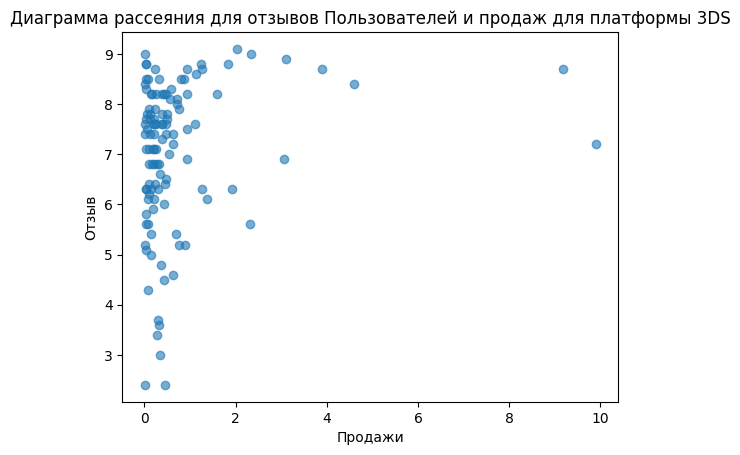

Коэффициент кореляции продаж и отзывов пользователей платформы 3DS: 0.19758263411038599


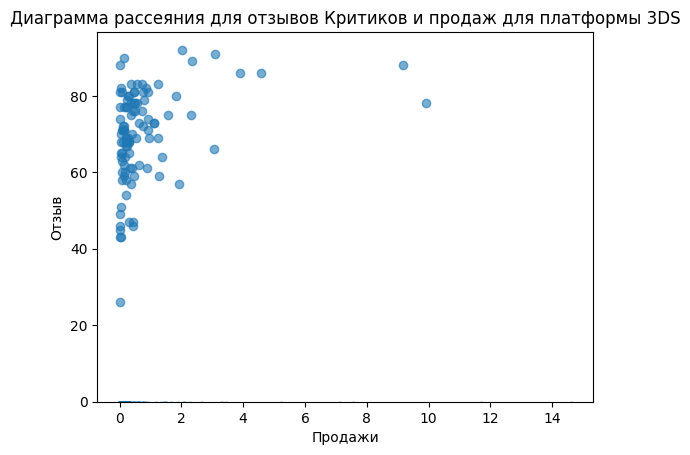

Коэффициент кореляции продаж и отзывов критиков платформы 3DS: 0.14986409095832484


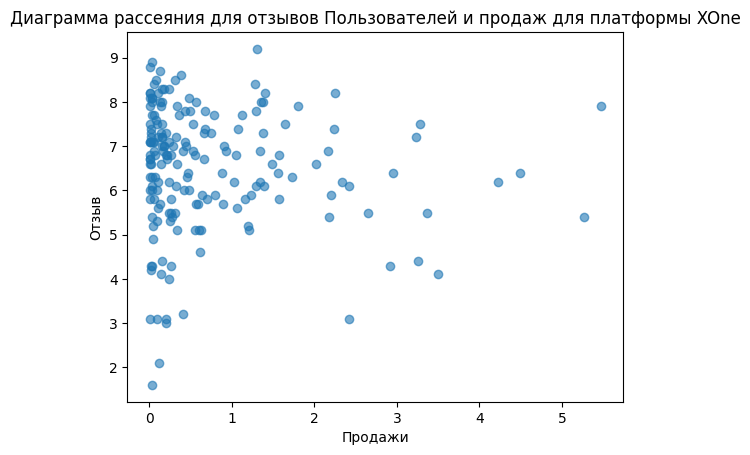

Коэффициент кореляции продаж и отзывов пользователей платформы XOne: -0.06892505328279414


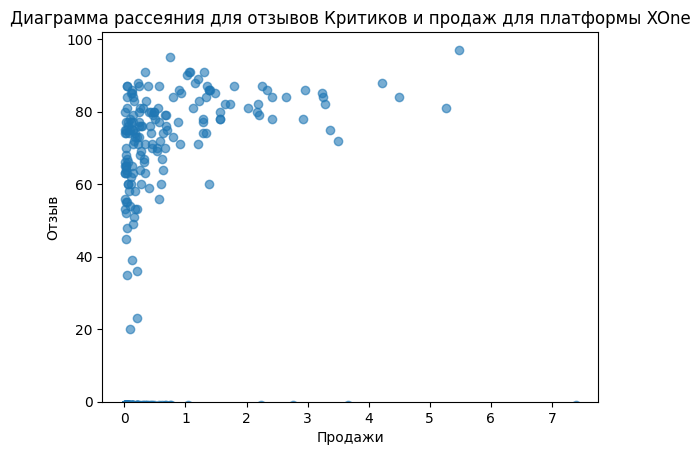

Коэффициент кореляции продаж и отзывов критиков платформы XOne: 0.27378217261702115


In [ ]:
# обновим список популярных платформ в сответствии с актуальным периодом. Выберем 5 самый популярных
top_platforms = df_actual.groupby('platform')['sales_all'].sum().sort_values(ascending=False).index[:5]

for platform in top_platforms:
    plat_data = df_actual[df_actual['platform'] == platform]

    # Строим диаграмму рассеяния для пользователей
    plt.scatter(plat_data['sales_all'], plat_data['user_score'], alpha=0.6)
    plt.xlabel('Продажи')
    plt.ylabel('Отзыв')
    plt.title(f'Диаграмма рассеяния для отзывов Пользователей и продаж для платформы {platform}')
    plt.show()

    # Посчитаем коэффициент корелляции Пирсона
    correlation = plat_data['user_score'].corr(plat_data['sales_all'])
    print(f'Коэффициент кореляции продаж и отзывов пользователей платформы {platform}: {correlation}')

    # Строим диаграмму рассеяния для критиков
    plt.scatter(plat_data['sales_all'], plat_data['critic_score'], alpha=0.6)
    plt.ylim(0)
    plt.xlabel('Продажи')
    plt.ylabel('Отзыв')
    plt.title(f'Диаграмма рассеяния для отзывов Критиков и продаж для платформы {platform}')
    plt.show()

    # Посчитаем коэффициент корелляции Пирсона
    correlation = plat_data['critic_score'].corr(plat_data['sales_all'])
    print(f'Коэффициент кореляции продаж и отзывов критиков платформы {platform}: {correlation}')


Исходя из диаграмм и коэффициентов кореляции продаж и отзывов **пользователей**, в диапазон от 0.2 до 0.5 попадают только значения **PS3**, а значит **есть слабая связь**. Это позволяет предполагать что пользователи платформы PS3 склонны прислушивться к мнению друг друга в вопросе выбора игр.

Кореляция продаж и отзывов **критиков**. В диапазон слабой связи от попали **все** популярные платформы, **кроме 3DS**. Получается  пользователи популярных платформ иногда ориентируются на отзывы критиков при выборе игры. В среднем чаще приобретая игры с рейтингом **от 70 до 90**. А вот пользователи платформы 3DS не склонны интересоваться чужим мнением.

## Соотнесите выводы с продажами игр на других платформах.

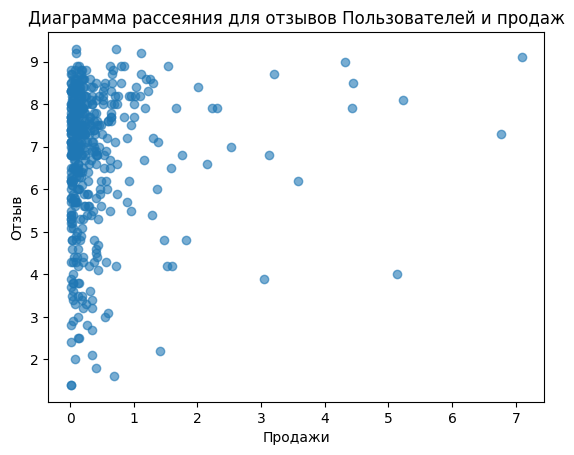

Коэффициент кореляции продаж и отзывов пользователей:  0.07672588258303085


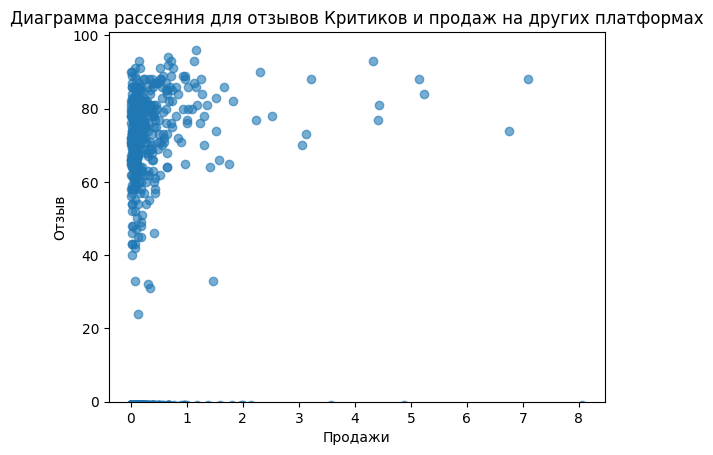

Коэффициент кореляции продаж других платформ и отзывов критиков:  0.24184217173179248


In [ ]:

other_data = df_actual[df_actual['platform'].isin(top_platforms) == False]

# Строим диаграмму рассеяния для пользователей
plt.scatter(other_data['sales_all'], other_data['user_score'], alpha=0.6)
plt.xlabel('Продажи')
plt.ylabel('Отзыв')
plt.title('Диаграмма рассеяния для отзывов Пользователей и продаж')
plt.show()

# Посчитаем коэффициент корелляции Пирсона
correlation = other_data['user_score'].corr(other_data['sales_all'])
print('Коэффициент кореляции продаж и отзывов пользователей: ', correlation)

# Строим диаграмму рассеяния для Критиков
plt.scatter(other_data['sales_all'], other_data['critic_score'], alpha=0.6)
plt.ylim(0)
plt.xlabel('Продажи')
plt.ylabel('Отзыв')
plt.title('Диаграмма рассеяния для отзывов Критиков и продаж на других платформах')
plt.show()

# Посчитаем коэффициент корелляции Пирсона
correlation = other_data['critic_score'].corr(other_data['sales_all'])
print('Коэффициент кореляции продаж других платформ и отзывов критиков: ', correlation)

**В обоих случаях** прослеживается **слабая связь** между отзывами и обьемами продаж. Пользователи менее популярных платформ в целом более склонны к доверию, и учитывают чужие мнения при выборе игры.



## Посмотрите на общее распределение игр по жанрам.
Что можно сказать о самых **прибыльных жанрах**? Выделяются ли жанры с высокими и низкими продажами?


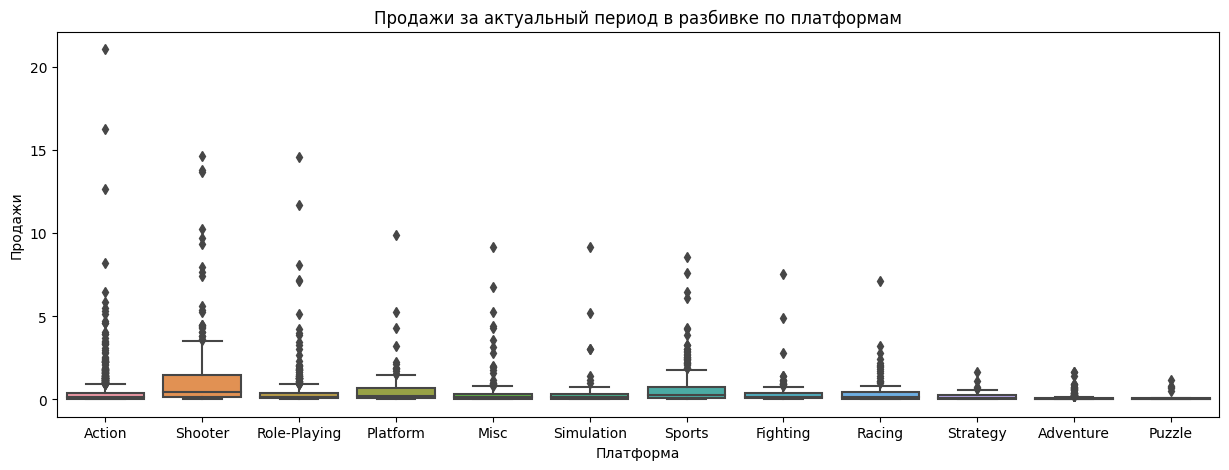

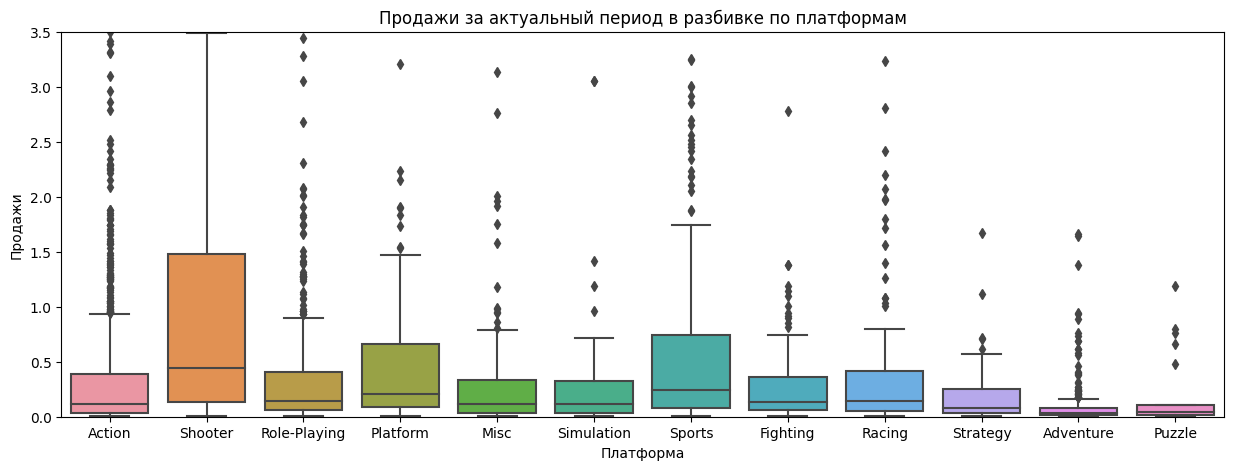

array([<Axes: ylabel='sales_all'>], dtype=object)

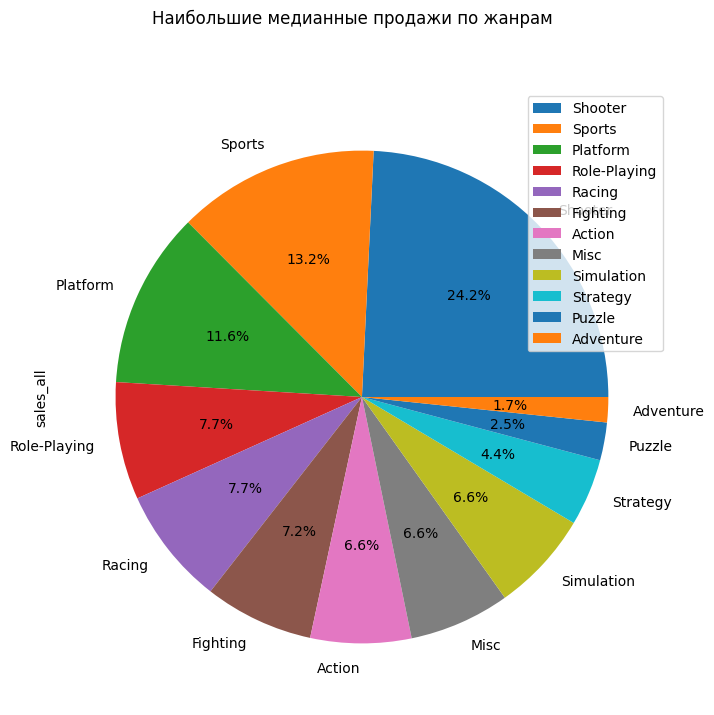

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="genre", y="sales_all", data=df_actual)
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Продажи за актуальный период в разбивке по платформам')
plt.show()

plt.figure(figsize=(15,5))
sns.boxplot(x="genre", y="sales_all", data=df_actual)
plt.ylim(0,3.5)
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Продажи за актуальный период в разбивке по платформам')
plt.show()

(
    df_actual
    .pivot_table(index='genre', values='sales_all', aggfunc='median')
    .sort_values('sales_all', ascending = False)
    .plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.1f%%', title='Наибольшие медианные продажи по жанрам')
)




В данных видно большое количество выбросов, что сильно влияет на среднее и суммарные значения. Стабильный спрос можно оценить  по медиане продаж.

ТОП-3 жанров по продажам:
1.   **Shooter**:  24.2% рынка
2.   **Action**: 13.2% рынка
3.   **Platform**:  11.6% рынка

Хуже всего продаются игры в жанрах Adventure, Puzzle, Strategy - в сумме составляющие **8,6%** всего рынка продаж видеоигр.

# Шаг 4. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (**NA, EU, JP**):

## Популярность платформ в регионах

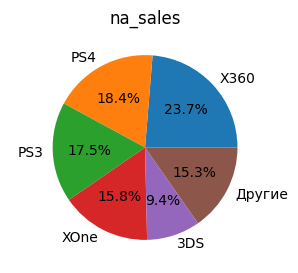

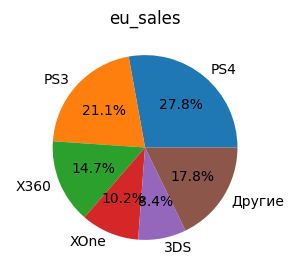

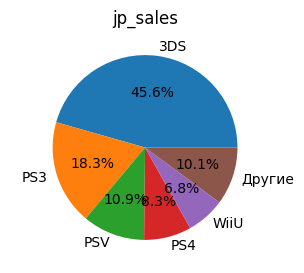

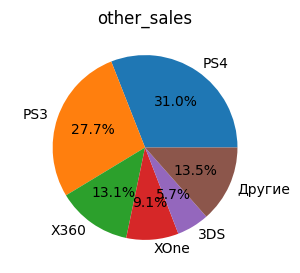

In [ ]:
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

for region in regions:
    all_platforms = df_actual.pivot_table(index='platform', values=region, aggfunc='sum').sort_values(region, ascending=False)
    top_5_platforms = all_platforms.head(5)
    others_sum = all_platforms.iloc[5:].sum()

    platforms = top_5_platforms.copy()
    platforms.loc['Другие'] = others_sum

    platforms.plot(kind='pie', y=region, figsize=(3, 3), legend=False, autopct='%1.1f%%', title=f'{region}')
    plt.ylabel(' ')
    plt.show()


1. В топ-5 платформ всех регионов входят: **PS4, PS3, 3DS**.

2. Для **Северной Америки и Европы** новому поколению Xbox, в отличие от нового поколения Playstation, пока не удалось победить предшественника по продажам. Таким образом первое место по подажам в Северной америке до сих пор удерживает X360, а следом PS4

3. Картина продаж сильно разнится в **Японии** , где на долю **Nintendo 3DS** выходит почти половина рынка. Как не странно второе место по продажам все еще занимают игры для PS3, а следом идет контент для Playstation Vita. Новому поколению Playstation еще не удалось завоевать большой популярности на родном рынке. Американские консоли не пользуются популярностью у Японцев.

4. В нерассматриваемых регионах ситуация по платформам игр в целом схожа с Европейскими тенденциями.

## Популярность жанров в регионах

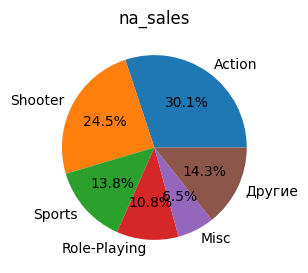

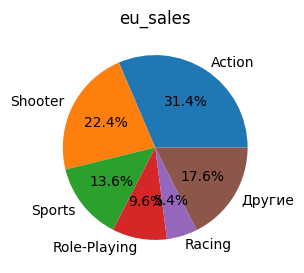

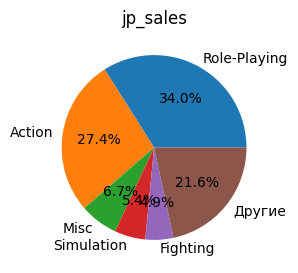

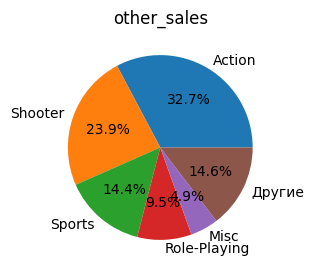

In [ ]:
for region in regions:
    all_genres = df_actual.pivot_table(index='genre', values=region, aggfunc='sum').sort_values(region, ascending=False)
    top_5_genres = all_genres.head(5)
    others_sum = all_genres.iloc[5:].sum()

    # Создаем новый DataFrame с добавлением категории "Другие"
    genres = top_5_genres.copy()
    genres.loc['Другие'] = others_sum

    genres.plot(kind='pie', y=region, figsize=(3, 3), legend=False, autopct='%1.1f%%', title=f'{region}')
    plt.ylabel(' ')
    plt.show()

1. Жанровые предпочтения **в Европе и Северной Америке в целом идентичны**. Различия в замыкающем ТОП-5 жанре. В Европе больше предпочтения отдают **гонкам**, а Северной Америке играм **разнородных жанров**.

2. Совершенно иная картина в Японии, где лидирующие позиции удерживают игры в жанре **Role-Play**, они вместе с играми жанра Action занимают больше половины рынка в Японии. Следом идут игры разнородных жанров, а пятерку лидеров замыкают жанры, малопопулярные за пределами Японии: **Simulation, Fighting**

3. В нерассматриваемых регионах в целом картина **идентична Северной Америке**

## Популярность по рейтингу ESRB

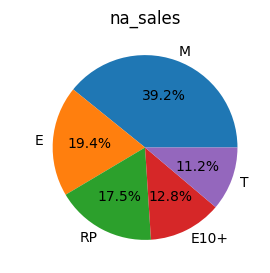

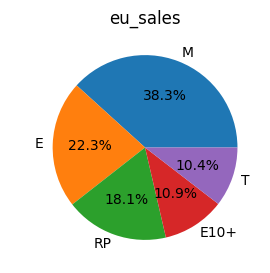

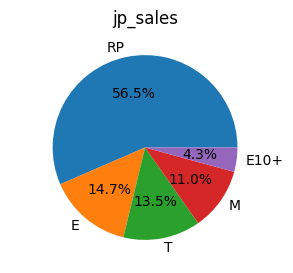

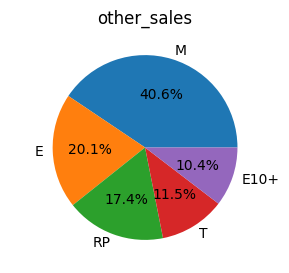

In [ ]:
for region in regions:
    ratings = df_actual.pivot_table(index='rating', values=region, aggfunc='sum').sort_values(region, ascending=False)
    ratings.plot(kind='pie', y=region, figsize=(3, 3), legend=False, autopct='%1.1f%%', title=f'{region}')
    plt.ylabel(' ')
    plt.show()

1. Рынок продаваемых в Северной Америке и Европе игр в целом подчиняется возрастным критериям. Так почти **40%** проданных игр были для лиц **старше 17-ти лет**. Следом (20%) идут игры без ограничений по возрасту. Важно отметить, что игры, которые не прошли соответств. рейтинговую сертификацию занимают **третью позицию**, то есть продаются чаще чем игры с рейтингом 10+ и 13+

2. Рынок Японии наполовину наводнен играми без рейтинга ESRB. Это может говорить о недостаточной регулируемости этой сферы государством, либо оно использует другие рейтинги возрастной оценки. Из того, что прошло сертификацию это примущественно игры без ограничений по возрасту, либо подростковые, 13+ лет. Игры для лиц старше 17-ти лет заняли предпоследнюю строчку.

3. Ситуация в нерассматриваемых регионах в целом схожа с таковой в Европе и Северной Америке, то есть рейтинг ESRB применяется во многих странах, но подрастковы игры 13+ в них продаются чаще, чем 10+. В целом это может быть связано с экономической ситуацией в регионазх, где продаются игры, например, возраст когда начинают играть в видеоигры там старше.

>  В топ-5 платформ всех регионов входят: **PS4, PS3, 3DS**.

>  Первое место по подажам в Северной америке до сих пор удерживает X360, а следом PS4.
Жанровые предпочтения **в Европе и Северной Америке в целом идентичны**. Action и Shooter занимают половину рынка. В Европе больше предпочтения отдают **гонкам**, а Северной Америке играм **разнородных жанров**.
Рынок продаваемых в Северной Америке и Европе игр в целом подчиняется возрастным критериям. Так почти 40% проданных игр были для лиц старше 17-ти лет. Следом (20%) идут игры без ограничений по возрасту.

>  В **Японии** на долю **Nintendo 3DS** выходит почти половина рынка. Второе место по продажам все еще занимают игры для PS3, а следом идет контент для Playstation Vita. Американские платформы не пользуются популярностью населения Японии.
Лидирующие позиции в жанрах удерживают игры **Role-Play**, они вместе с играми жанра Action занимают больше половины рынка в Японии. Следом идут игры разнородных жанров, а пятерку лидеров замыкают жанры, малопопулярные за пределами Японии: **Simulation, Fighting**
Рынок Японии наполовину из игр без рейтинга ESRB. Из того, что прошло сертификацию это примущественно игры без ограничений по возрасту, либо подростковые, 13+ лет. Игры для лиц старше 17-ти лет заняли предпоследнюю строчку.

> В нерассматриваемых регионах ситуация по платформам, жанрам игр в целом схожа с Европейскими тенденциями. Рейтинг ESRB применяется во многих странах, но подростковы игры 13+ в них продаются чаще, чем 10+.


# Шаг 5. Проверьте гипотезы

## Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Критерий alpha в 5% был использова потому, что данные в исследованиях не требует особой точности, при этом порог в 5% считается приемлемы для выводов о представленных выборках.


**Нулевая гипотеза**: Среднее польз. рейтинга платформы PC равно среднему пользовательскому рейтингу платформы Xbox One

**Альтернативная**: Среднее польз. рейтинга платформы PC не равно среднему пользовательскому рейтингу платформы Xbox One

H0=H1 Двусторонняя альтернативная гипотеза т.к. мы не сравниваем значения, а искомое отклонение может быть как больше, так и меньше.

In [ ]:
PC = df_actual.query('platform == "PC"')['user_score'].dropna() #  рейтинг PC
XOne = df_actual.query('platform == "XOne"')['user_score'].dropna() # рейтинг Xbox One
print('Средний польз. рейтинг PC: ', PC.mean())
print('Средний польз. рейтинг XOne: ', XOne.mean())
alpha = .05  # уровень статистической значимости

levene_test = levene(PC, XOne) # определяем дисперсии выборок, чтобы решить указывать нам параметр equal_var или нет.
print('p-значение теста Левена: ', levene_test.pvalue)

if levene_test.pvalue > alpha:
    equal_var = True
else:
    equal_var = False
    print('Дисперсии выборок разные: equal_var = False')

results = st.ttest_ind(XOne, PC, equal_var=equal_var) # определяет стат. значимость РАЗЛИЧИЯ средних значений.
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу ")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")



Средний польз. рейтинг PC:  6.4286407766990274
Средний польз. рейтинг XOne:  6.521428571428572
p-значение теста Левена:  0.01251484281850554
Дисперсии выборок разные: equal_var = False
p-значение:  0.5489537965134912
Не получилось отвергнуть нулевую гипотезу.


**Вывод:** По имеющимся данным, при уровне значимости 5%, оснований для отвержения нулевой гипотезы **нет**. 0.056 > 0.050 (alpha)

## Гипотеза 2: Средние пользовательские рейтинги жанров **Action**  и **Sports** разные.

**Нулевая гипотеза**: Среднее польз. рейтинга жанра Action равно среднему пользовательскому рейтингу жанра Sports

**Альтернативная**: Среднее польз. рейтинга жанра Action не равно среднему пользовательскому рейтингу жанра Sports

**H0!=H1** Двусторонняя альтернативная гипотеза т.к. мы не сравниваем значения, а искомое отклонение может быть как больше, так и меньше.

In [ ]:
Action = df_actual.query('genre == "Action"')['user_score'].dropna() #  рейтинг Action
Sports = df_actual.query('genre == "Sports"')['user_score'].dropna() # рейтинг Sports

print('Средний польз. рейтинг жанра Action: ', Action.mean())
print('Средний польз. рейтинг жанра Sports: ', Sports.mean())

alpha = .05  # уровень статистической значимости

levene_test = levene(Action, Sports) # определяем дисперсии выборок, чтобы решить указывать нам параметр equal_var или нет.
print("p-значение теста Левена:", levene_test.pvalue)
if levene_test.pvalue > alpha:
    equal_var = True
else:
    equal_var = False
    print('Дисперсии выборок разные: equal_var = False')

results = st.ttest_ind(Action, Sports, equal_var=equal_var)
print('p-значение: ', results.pvalue, ) #

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу ")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")


Средний польз. рейтинг жанра Action:  6.825047801147227
Средний польз. рейтинг жанра Sports:  5.455670103092784
p-значение теста Левена: 1.045718795108326e-05
Дисперсии выборок разные: equal_var = False
p-значение:  5.989458066467418e-20
Отвергаем нулевую гипотезу 


**Вывод:** По имеющимся данным, при уровне значимости 5%, **есть** основания для отвержения нулевой гипотезы. 5.989x10^-20 < 0.05(alpha)

Нулевая гипотеза всегда утверждает равенство двух исследуемых групп. Алтернативная же наоборот утверждает НЕравенство.

Мы выбрали **двухвыборочный t-критерий для независимых выборок**, потому что:
1. Сравниваем Средние двух Независимых, НЕ связанных между собой двух групп жанров.
2. Он стойчив к небольшим отклонениям от нормальности, особенно при больших выборках и благодаря ЦПТ может быть применен к выборкам любого размера при условии соблюдения других предположений.

# Шаг 6. Напишите общий вывод

Закономерности, определяющие успешность игры:

 1. 2 платформы: **PS4, 3DS** будут акутуальны в течение ближайших 4-х лет.
 2. 3 популярных жанра: **Shooter, Action, Platform**. Региональная особенность: в Японии наибольшей популярностью пользуется жанр **Role-Play**.
 3 наименее популярные платформы: **Adventure, Puzzle, Strategy**
 3. 2 популярных рейтинга ESRB: **M, E**. Региональная особенность: в Японии своя рейтинговая организация CERO, поэтому рейтинг ESRB в целом там не популярен. Однако из того, что есть на рынке с рейтингом это игры категории E и T.
 4. Пользователи всех платформ при выборе игр склонны ориентироваться на **отзывы критиков**.


